In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
train_path = Path('../Data/cats_dogs_dataset/train/')
test_path = Path('../Data/cats_dogs_dataset/valid/')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df(train_path):
    files = filelist(train_path, '.txt')
    annotations = []
    for file in files:
        filedata = {}
        label, xmin, ymin, xmax, ymax = open(file, 'r').readline().split()
        filedata['filename'] = file.replace('.txt', '.jpg')
        filedata['class'] = label
        filedata['xmin'] = xmin
        filedata['ymin'] = ymin
        filedata['xmax'] = xmax
        filedata['ymax'] = ymax
        annotations.append(filedata)
    return pd.DataFrame(annotations)

In [4]:
df_train = generate_train_df(train_path)
print(df_train.shape)
df_train.head()

(2985, 6)


,class,filename,xmax,xmin,ymax,ymin
0,1,..\Data\cats_dogs_dataset\train\Abyssinian_1.jpg,425,333,158,72
1,1,..\Data\cats_dogs_dataset\train\Abyssinian_10.jpg,288,72,291,105
2,1,..\Data\cats_dogs_dataset\train\Abyssinian_100...,335,151,267,71
3,1,..\Data\cats_dogs_dataset\train\Abyssinian_101...,319,54,235,36
4,1,..\Data\cats_dogs_dataset\train\Abyssinian_102...,325,23,320,27


In [5]:
#label encode target
class_dict = {'1': 0, '2': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [6]:
print(df_train.shape)
df_train.head()

(2985, 6)


,class,filename,xmax,xmin,ymax,ymin
0,0,..\Data\cats_dogs_dataset\train\Abyssinian_1.jpg,425,333,158,72
1,0,..\Data\cats_dogs_dataset\train\Abyssinian_10.jpg,288,72,291,105
2,0,..\Data\cats_dogs_dataset\train\Abyssinian_100...,335,151,267,71
3,0,..\Data\cats_dogs_dataset\train\Abyssinian_101...,319,54,235,36
4,0,..\Data\cats_dogs_dataset\train\Abyssinian_102...,325,23,320,27


In [7]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[3],x[4],x[2]])

def resize_image_bb(read_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(read_path).replace('train', 'resized')
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [8]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [9]:
im = cv2.imread(df_train.values[0][1])
bb = create_bb_array(df_train.values[0])
print(im.shape)
print(bb)

(400, 600, 3)
['72' '333' '158' '425']


In [10]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 72., 333., 157., 424.], dtype=float32)

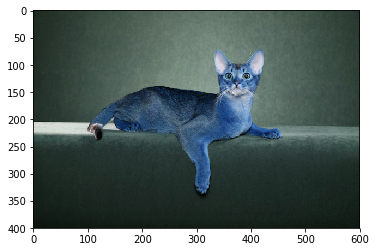

In [11]:
plt.imshow(im)

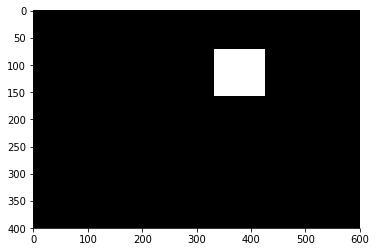

In [12]:
plt.imshow(Y, cmap='gray')

In [13]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)